# BO RDB v
* save, maxmemroy 반영 후
* throughtput 값 40000대부터 시작

* 모델 생성
* 목적함수 생성

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

## Model 생성

### knobs 종류, 바운드 입력

In [2]:
knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
    "rdbchecksum": ('yes', 'no'),    ##yes
    "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

#     "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
#     "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
#                              "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

In [3]:
# 확인
print(knobs_list)
print(knobs_bound)

['hash-max-ziplist-entries', 'hash-max-ziplist-value', 'activerehashing', 'hz', 'dynamic-hz', 'save0_0', 'save0_1', 'save1_0', 'save1_1', 'save2_0', 'save2_1', 'rdbcompression', 'rdbchecksum', 'rdb-save-incremental-fsync', 'active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max', 'maxmemory', 'maxmemory-samples', 'lazyfree-lazy-eviction', 'lazyfree-lazy-expire', 'lazyfree-lazy-server-del']
[(256, 751), (16, 257), ('yes', 'no'), (1, 41), ('yes', 'no'), (700, 1100), (1, 9), (100, 500), (10, 100), (30, 90), (8000, 12000), ('yes', 'no'), ('yes', 'no'), ('yes', 'no'), (1, 31), (70, 101), (1, 31), (70, 91), (1000, 2900), (3, 7), ('yes', 'no'), ('yes', 'no'), ('yes', 'no')]


# 0. config data의 csv 파일 처리
csv 파일은 confile.conf 파일에서 선별한 knob 값들을 파싱하여 저장된 상태이다. 
* config_df 는 랜덤하게 값을 할당한 모든 변수 존재한다. 
* 부분적으로 knob 선별 작업 필요!

### csv 파일 가져오기

In [4]:
# config data(.csv) -> DataFrame
config_df = pd.read_csv("./data/result_config0.csv", sep=',')

In [5]:
# 확인
config_df.dtypes

appendonly                       float64
appendfsync                      float64
auto-aof-rewrite-percentage      float64
auto-aof-rewrite-min-size        float64
no-appendfsync-on-rewrite        float64
aof-rewrite-incremental-fsync    float64
aof-use-rdb-preamble             float64
save0_0                            int64
save0_1                            int64
save1_0                            int64
save1_1                            int64
save2_0                            int64
save2_1                            int64
rdbcompression                    object
rdbchecksum                       object
rdb-save-incremental-fsync        object
activedefrag                      object
active-defrag-threshold-lower    float64
active-defrag-threshold-upper    float64
active-defrag-cycle-min          float64
active-defrag-cycle-max          float64
maxmemory                         object
maxmemory-policy                  object
maxmemory-samples                  int64
lazyfree-lazy-ev

### maxmemory 처리

In [6]:
config_df['maxmemory']  = config_df['maxmemory'].str.strip('mb')

In [7]:
config_df['maxmemory'] = pd.to_numeric(config_df['maxmemory'])

In [8]:
# 확인
print(config_df['maxmemory'])
print(config_df.dtypes)

0       2700
1       2200
2       1700
3       1000
4       1900
        ... 
2495    2800
2496    1500
2497    2900
2498    2200
2499    1400
Name: maxmemory, Length: 2500, dtype: int64
appendonly                       float64
appendfsync                      float64
auto-aof-rewrite-percentage      float64
auto-aof-rewrite-min-size        float64
no-appendfsync-on-rewrite        float64
aof-rewrite-incremental-fsync    float64
aof-use-rdb-preamble             float64
save0_0                            int64
save0_1                            int64
save1_0                            int64
save1_1                            int64
save2_0                            int64
save2_1                            int64
rdbcompression                    object
rdbchecksum                       object
rdb-save-incremental-fsync        object
activedefrag                      object
active-defrag-threshold-lower    float64
active-defrag-threshold-upper    float64
active-defrag-cycle-min          f

### null 값 처리

In [9]:
# fillna(value = 0) 0 값으로 채워 넣기
config_df = config_df.fillna(value = 0)

In [10]:
# 확인
## 확인 결과 모두 값이 0이면 제거하는 것이 좋다. !! 자동화 코드 만들 필요!
config_df.head()

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,805,5,178,...,volatile-lru,5,no,yes,yes,258,253,no,7,yes
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1097,3,499,...,allkeys-random,3,yes,yes,yes,360,226,yes,32,yes
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1018,2,497,...,allkeys-lfu,3,yes,yes,yes,364,136,yes,40,no
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,858,5,423,...,noeviction,3,no,yes,no,417,173,no,37,no
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,727,6,230,...,allkeys-random,4,no,yes,no,522,141,yes,30,yes


### 카테고리 형 처리
* numeric
* category

애초에 위 두가지 형태 밖에 존재하지 않는다. numeric의 경우 모두 numeric으로 처리가 된 상태이며, category의 경우 object로 처리가 될것이다. 따라서 Object인 경우에만 category형태로 타입을 변경해준다.

In [11]:
category_knob = []

for knob in config_df:
    if config_df[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        config_df[knob] = config_df[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)
#         category_knob.append(knob)

        
# print(category_knob)
# knob list에 없는 경우 제거
# for knob in category_knob:
#     print(knob)
    
#     if knob not in knobs_list:
#         print(knob)
#         category_knob.remove(knob)
        

In [12]:
# 확인
category_knob

['rdbcompression',
 'rdbchecksum',
 'rdb-save-incremental-fsync',
 'lazyfree-lazy-eviction',
 'lazyfree-lazy-expire',
 'lazyfree-lazy-server-del',
 'activerehashing',
 'dynamic-hz']

### knob 추출

In [13]:
# knob 들만 추출
config_df_knob = config_df.loc[:,knobs_list]

In [14]:
# 확인
config_df_knob.head()

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,rdb-save-incremental-fsync,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del
0,258,253,no,7,yes,805,5,178,91,36,...,no,23.0,84.0,24.0,72.0,2700,5,no,yes,yes
1,360,226,yes,32,yes,1097,3,499,33,82,...,no,25.0,100.0,13.0,80.0,2200,3,yes,yes,yes
2,364,136,yes,40,no,1018,2,497,23,36,...,yes,17.0,79.0,30.0,71.0,1700,3,yes,yes,yes
3,417,173,no,37,no,858,5,423,14,80,...,no,12.0,77.0,17.0,89.0,1000,3,no,yes,no
4,522,141,yes,30,yes,727,6,230,54,61,...,no,9.0,87.0,13.0,85.0,1900,4,no,yes,no


### 모두 값이 0일 경우 제거

### result.csv 파일 가져오기

In [15]:
# external data(.csv) -> DataFrame
external_df = pd.read_csv("./data/external_metrics0.csv", sep=',')
throughput_data = external_df['Gets_KB/sec']

In [16]:
# throuput 값으로 예상 확인
external_df['Gets_KB/sec']

0       61645.41
1       63270.32
2       63602.49
3       63679.99
4       60092.30
          ...   
2495    58900.45
2496    62418.19
2497    60296.22
2498    62108.52
2499    63440.13
Name: Gets_KB/sec, Length: 2500, dtype: float64

In [17]:
print("max: {}".format(max(external_df['Gets_KB/sec'])))
print("min: {}".format(min(external_df['Gets_KB/sec'])))

max: 66377.65
min: 47520.43


In [18]:
# 40000~ 50000대 확인
index1 = (external_df['Gets_KB/sec'] >= 47520.43)
index2 = (external_df['Gets_KB/sec'] <= 50000)

external_df[index2]

,Sets_Ops/sec,Sets_Hits/sec,Sets_Misses/sec,Sets_Avg_Latency,Sets_p50_Latency,Sets_p99_Latency,Sets_p100_Latency,Sets_KB/sec,Gets_Ops/sec,Gets_Hits/sec,...,Waits_p100_Latency,Waits_KB/sec,Totals_Ops/sec,Totals_Hits/sec,Totals_Misses/sec,Totals_Avg_Latency,Totals_p50_Latency,Totals_p99_Latency,Totals_p100_Latency,Totals_KB/sec
1662,24075.97,NaN,NaN,0.040,2633.31,24075.97,35.73,24040.24,0.039,848.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1795,23760.21,NaN,NaN,0.041,2598.77,23760.21,35.26,23724.95,0.039,837.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918,24511.73,NaN,NaN,0.040,2680.97,24511.73,36.38,24475.36,0.038,864.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2277,24242.70,NaN,NaN,0.040,2651.55,24242.70,35.98,24206.72,0.039,854.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2437,23771.61,NaN,NaN,0.041,2600.02,23771.61,35.32,23736.29,0.039,838.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# 60000대 확인
index3 = (external_df['Gets_KB/sec'] >= 65000)

external_df[index3]['Gets_KB/sec']

31      65011.44
280     65632.04
281     65767.16
282     66377.65
285     65321.22
288     66161.63
2007    65339.15
2010    65185.13
2036    65146.51
2051    65367.86
Name: Gets_KB/sec, dtype: float64

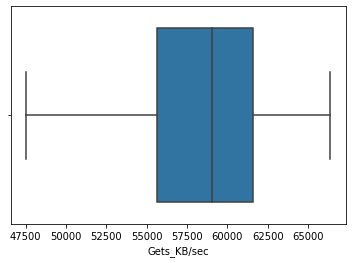

In [20]:
import seaborn as sns
sns.boxplot(x = "Gets_KB/sec",data = external_df )
plt.show()

In [21]:
# 히스토그램


### train, test 데이터 분리

In [22]:
# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(config_df_knob, throughput_data ,test_size=0.2)

#lightGBM 파라미터 설정
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

# 모델 생성
lgbr = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

# 모델 fitting
lgbr.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid's auc: 1


/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


LGBMRegressor(colsample_bytree=0.9, metric='None', n_estimators=1000, n_jobs=4,
              num_leaves=15, random_state=314, subsample=0.9)

In [23]:
# 확인
y_predict = lgbr.predict(X_test)

In [24]:
print(lgbr)

LGBMRegressor(colsample_bytree=0.9, metric='None', n_estimators=1000, n_jobs=4,
              num_leaves=15, random_state=314, subsample=0.9)


---

# Bayeian Optimization 진행

### Objective Function 생성

In [25]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):
    knob_dict = {}

    for i, knob in enumerate(knobs_list): # 딕셔너리로 이동
        knob_dict[knob] = knob_value[i]
        
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0     
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    # 카테고리 변수 변경
    for knob in category_knob:
        knob_df[knob] = knob_df[knob].astype('category') 

    return -lgbr.predict(knob_df)[0]


#     change_numeric = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']


## gp_minimize 호출

In [26]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [27]:
res = gp_minimize(objective_func,                  # the function to minimize
                  knobs_bound,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=20,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [28]:
res.x

[316,
 58,
 'no',
 27,
 'yes',
 928,
 6,
 247,
 96,
 42,
 11400,
 'yes',
 'no',
 'no',
 9,
 91,
 6,
 78,
 1027,
 4,
 'no',
 'no',
 'yes']

In [29]:
res.fun # 63000

-58869.53517089844

## total
hash-max-ziplist-entries 316
hash-max-ziplist-value 58 
activerehashing no
hz 27
dynamic-hz yes

save 928 6
save 247 96
save 42 11400

rdbcompression yes
rdbchecksum no
rdb-save-incremental-fsync no

activedefrag yes
active-defrag-threshold-lower 9
active-defrag-threshold-upper 91
active-defrag-cycle-min 6
active-defrag-cycle-max 78

maxmemory 1027
maxmemory-policy volatile-lru
maxmemory-samples 4

lazyfree-lazy-eviction no
lazyfree-lazy-expire no
lazyfree-lazy-server-del yes



## test group3개
hash-max-ziplist-entries 538 
hash-max-ziplist-value 167
activerehashing no
hz 10
dynamic-hz yes

save 1088 6
save 291 14
save 88 11092

rdbcompression no
rdbchecksum no
rdb-save-incremental-fsync yes

activedefrag yes
active-defrag-threshold-lower 5
active-defrag-threshold-upper 101
active-defrag-cycle-min 29
active-defrag-cycle-max 86

maxmemory 1333
maxmemory-policy volatile-lru
maxmemory-samples 5

lazyfree-lazy-eviction no
lazyfree-lazy-expire yes
lazyfree-lazy-server-del yes

## total
hash-max-ziplist-entries 538 
hash-max-ziplist-value 167
activerehashing no
hz 10
dynamic-hz yes

save 1088 6
save 291 14
save 88 11092

rdbcompression no
rdbchecksum no
rdb-save-incremental-fsync yes

activedefrag yes
active-defrag-threshold-lower 5
active-defrag-threshold-upper 101
active-defrag-cycle-min 29
active-defrag-cycle-max 86

maxmemory 1333
maxmemory-policy volatile-lru
maxmemory-samples 5

lazyfree-lazy-eviction no
lazyfree-lazy-expire yes
lazyfree-lazy-server-del yes

In [3]:
import numpy as np
def sigmoid(x):
    return 1 / (1 +np.exp(-x))

In [4]:
sigmoid(0.60)*(1-sigmoid(0.60))

0.22878424045665732

In [5]:
0.05*0.22*0.51

0.00561

In [6]:
0.4+0.4*0.00561

0.40224400000000005

In [9]:
sigmoid(0.45*0.51+0.55*0.51)

0.6248064744684293

In [12]:
0.4+0.4*(0.12)

0.448